In [20]:
# import libraries

import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [21]:
# SET DATASET PATHS

# Original dataset folder (from Kaggle)
source_dataset = r"C:\Users\ramit\OneDrive\Desktop\project\dataset"

# Output folder where split dataset will be stored
output_dataset = r"C:\Users\ramit\OneDrive\Desktop\project\corn_split_dataset"

# CREATE TRAIN/TEST FOLDERS

classes = os.listdir(source_dataset)

for split in ["train", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(output_dataset, split, cls), exist_ok=True)

print("Folders created successfully!")

# SPLIT DATASET (80% TRAIN, 20% TEST)

for cls in classes:
    class_path = os.path.join(source_dataset, cls)
    images = os.listdir(class_path)

    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Copy train images
    for img in train_imgs:
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(output_dataset, "train", cls, img)
        )

    # Copy test images
    for img in test_imgs:
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(output_dataset, "test", cls, img)
        )

print("Dataset successfully split and copied!")

Folders created successfully!
Dataset successfully split and copied!


In [22]:
# Data Preprocessing

img_size = 128
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1/255.0)

train_gen = train_datagen.flow_from_directory(
    os.path.join(output_dataset, "train"),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(output_dataset, "test"),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3348 images belonging to 4 classes.
Found 840 images belonging to 4 classes.


In [23]:
# Build CNN model

model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),
    
    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.35),

    # Dense layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(4, activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,679,716 (33.11 MB)

 Trainable params: 8,678,308 (33.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [24]:
# Callbacks 

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    ModelCheckpoint("corn_best_model.keras", monitor='val_accuracy', save_best_only=True)
]

In [25]:
# Train model

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.7748 - loss: 0.6282 - val_accuracy: 0.2738 - val_loss: 2.6515
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.8441 - loss: 0.3836 - val_accuracy: 0.2774 - val_loss: 5.3026
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.8599 - loss: 0.3614 - val_accuracy: 0.2845 - val_loss: 4.9433
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - accuracy: 0.8623 - loss: 0.3714 - val_accuracy: 0.5607 - val_loss: 2.3390
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.8769 - loss: 0.3145 - val_accuracy: 0.2905 - val_loss: 4.7732
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.8904 - loss: 0.2951 - val_accuracy: 0.8869 - val_loss: 0.3261
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - accuracy: 0.8967 - loss: 0.2710 - val_accuracy: 0.8845 - val_loss: 0.3634
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 358s 3s/step - accuracy: 0.9050 - loss: 0.2451 - val_accu

In [26]:
# Evaluate accuracy

loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - accuracy: 0.9310 - loss: 0.1837
Test Accuracy: 93.10%


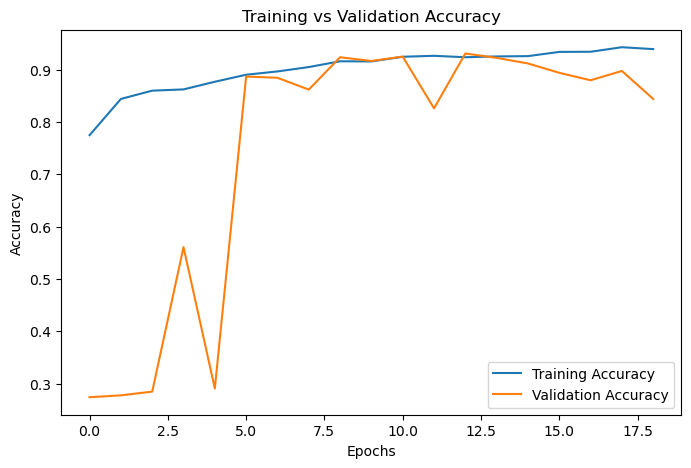

In [27]:
# Plot accuracy graph

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

In [29]:
# Save model

model.save("C:/Users/ramit/OneDrive/Desktop/project/corn_disease_model.keras")
print("Model saved as corn_disease_model.keras")

Model saved as corn_disease_model.keras
